<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    ML for Bioinformatics <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
<font color=3C99D size=5>
    Homework 2: Practical - Random Forest and XGboost <br>
<font color=696880 size=4>
    Bahar Oveisgharan (bahar.oveis.2000@gmail.com) <br>
    Ghazal Farahani (farahaniqazal@gmail.com)

____


### Full Name : Javad Razi
### Student Number : 401204354
__

### Breasr Cancer
Most of us know someone who struggled with breast cancer, or at least heard about the struggles facing patients who are fighting against breast cancer.The most important part of a process of clinical decision-making in patients with cancers, in general, is the accurate estimation of prognosis and survival duration. Breast cancer patients with the same stage of the disease and the same clinical characteristics can have different treatment responses and overall survival.
In this practical assignment, you are going to train a Random Forest and XGBoost model on <code>breast_cancer.csv</code> dataset.

Import all the libraries you may need here

In [30]:

import sklearn
import pandas as pd
import xgboost as xgb    

#### Loading the Data

In [31]:
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
# Load the dataset into a pandas dataframe
df = pd.read_csv('breast_cancer.csv')

### Data Exploration
#### Let's start off by exploring the files we just imported. it's not necessary to do any visualization just a statistical summary of the data would be enough. split your data to train and test.

In [32]:
from sklearn.model_selection import train_test_split


X = df.drop('overall_survival', axis=1)
y = df['overall_survival']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92847)

# Display a statistical summary of the data
print("Training set summary:")
print(X_train.describe())
print('*'*20)
print("Test set summary:")
print(X_test.describe())


Training set summary:
       Unnamed: 0  age_at_diagnosis  chemotherapy       cohort  neoplasm_histologic_grade  hormone_therapy  lymph_nodes_examined_positive  mutation_count  nottingham_prognostic_index  radio_therapy   tumor_size  tumor_stage
count  1523.00000       1523.000000   1523.000000  1523.000000                1523.000000      1523.000000                    1523.000000     1523.000000                  1523.000000    1523.000000  1523.000000  1523.000000
mean    959.58306         61.128431      0.210112     2.655942                   2.415709         0.621799                       2.017728        5.782804                     4.034162       0.598162    26.255389     1.752605
std     552.72670         12.956723      0.407521     1.222789                   0.635067         0.485097                       4.109420        4.160442                     1.132175       0.490431    15.103027     0.546869
min       1.00000         21.930000      0.000000     1.000000                   1

### Data Preparation
#### Creating two custom transformers to put on our pipeline:
* To split the data into categorical and numerical features and
* To preprocess the categorical features. 
* Create the X feature matrix and the y target vector.
* split the data.

In [33]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas dataframe
df = pd.read_csv('breast_cancer.csv').dropna()

# Define custom transformers
class CategoricalFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.select_dtypes(include=['object'])

class CategoricalPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        return ohe.fit_transform(X)

# Create X feature matrix and y target vector
X = df.drop('overall_survival', axis=1)
y = df['overall_survival']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=92847)

# Define the preprocessing pipeline
categorical_pipeline = Pipeline([
    ('cat_selector', CategoricalFeatureSelector()),
    ('cat_preprocessor', CategoricalPreprocessor())
])

preprocessing_pipeline = ColumnTransformer([
    ('cat_pipeline', categorical_pipeline, X.columns.tolist())
], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('scaler', StandardScaler())
])

x_preprocess_pipe = pipeline
X_preprocessed = pipeline.fit_transform(X)
X_train_preprocessed, X_test_preprocessed, y_train_preprocessed, y_test_preprocessed = train_test_split(X_preprocessed, y, test_size=0.2, random_state=92847)

# Implementing two different models

## Random Forest

### train the model

In [34]:
# Train a Random Forest model on the preprocessed data
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=100, random_state=92847)
rf_model.fit(X_train_preprocessed, y_train)


RandomForestClassifier(random_state=92847)

### Model assessment
#### Print Train Accuracy, Test Accuracy and classification Report.


In [35]:
from sklearn.metrics import classification_report


train_accuracy = rf_model.score(X_train_preprocessed, y_train)
test_accuracy = rf_model.score(X_test_preprocessed, y_test)
y_pred = rf_model.predict(X_test_preprocessed)

clf_report = classification_report(y_test, y_pred, output_dict=True)
print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)
pd.DataFrame(clf_report)

Train Accuracy:  0.9111842105263158
Test Accuracy:  0.618421052631579


,0,1,accuracy,macro avg,weighted avg
precision,0.687500,0.500000,0.618421,0.593750,0.615954
recall,0.702128,0.482759,0.618421,0.592443,0.618421
f1-score,0.694737,0.491228,0.618421,0.592982,0.617082
support,188.000000,116.000000,0.618421,304.000000,304.000000


### Hyperparameter tuning :
#### Randomized Search Cross Validation and Grid Search Cross Validation
report best hyperparameters in each part.

In [36]:

# Define the parameter grid for Randomized Search Cross Validation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


param_distributions = {
    'n_estimators': [50, 100, 150, 200, 500],
    'max_depth': [None, 3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt']
}

# Perform Randomized Search Cross Validation to find the best hyperparameters
rf_model = RandomForestClassifier(random_state=92847)
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions, n_iter=500, cv=5, random_state=92847, n_jobs=-1)
rf_random.fit(X_train_preprocessed, y_train)
print("Randomized Search CV best parameters:", rf_random.best_params_)

# Define the parameter grid for Grid Search Cross Validation
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Perform Grid Search Cross Validation to find the best hyperparameters
rf_grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train_preprocessed, y_train)
print("Grid Search CV best parameters:", rf_grid.best_params_)


Randomized Search CV best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 5}
Grid Search CV best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [37]:

# Make predictions on the test data using the trained model with best hyperparameters
rf_best_model = RandomForestClassifier(**rf_grid.best_params_, random_state=92847)
rf_best_model.fit(X_train_preprocessed, y_train)
y_test_pred = rf_best_model.predict(X_test_preprocessed)

# Evaluate the performance of the model on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test accuracy with best hyperparameters:", test_accuracy)
print(classification_report(y_test, y_test_pred))

Test accuracy with best hyperparameters: 0.6611842105263158
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       188
           1       0.56      0.50      0.53       116

    accuracy                           0.66       304
   macro avg       0.64      0.63      0.63       304
weighted avg       0.65      0.66      0.66       304



### Find important features with Random Forest model 
#### Visualize feature scores of the features

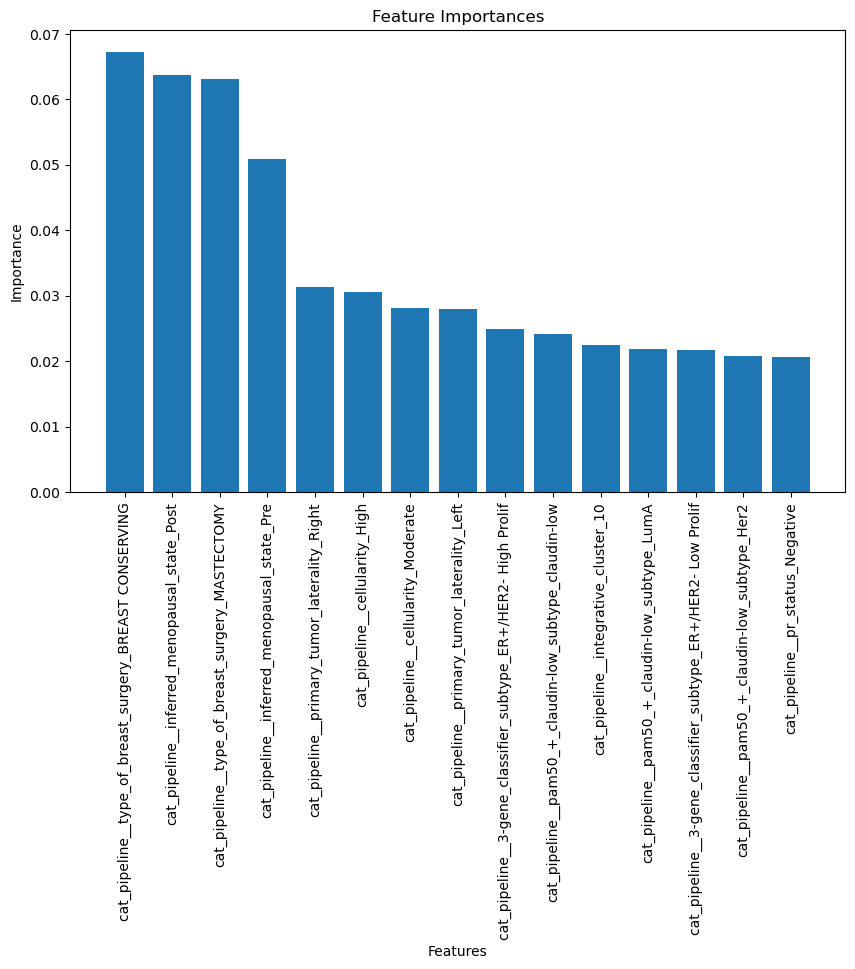

In [38]:
# Get the feature importances and sort them in descending order
from matplotlib import pyplot as plt


feature_importances = pd.DataFrame(rf_best_model.feature_importances_, index=X_preprocessed.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.iloc[:15, ]

# Visualize the feature importances as a bar plot
plt.figure(figsize=(10,6))
plt.bar(feature_importances.index, feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

### * Improve Model (Bonus)
In this bonus part, you can add your ideas for improving your model's performance. implement it and compare the results.

here are some ideas for improving the performance of the Random Forest model on the breast cancer dataset:

Feature Selection: One way to improve the performance of the model is to perform feature selection to identify and remove irrelevant or redundant features. This can simplify the model and reduce overfitting, leading to better generalization performance. We can use techniques like Recursive Feature Elimination (RFE), SelectKBest, or PCA for feature selection.

Ensemble Methods: Another way to improve the performance of the model is to use ensemble methods like bagging, boosting, or stacking. Bagging can reduce the variance of the model by training multiple instances of the same model on different subsets of the data and aggregating their predictions. Boosting can reduce the bias of the model by training multiple weak models on different subsets of the data and combining their predictions. Stacking can combine the predictions of multiple models with different strengths and weaknesses to improve the overall performance.

Model Tuning: We can further improve the performance of the model by tuning its hyperparameters using techniques like Randomized Search Cross Validation or Grid Search Cross Validation. This can help us find the optimal set of hyperparameters for the model that minimize the bias and variance.

In [39]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.metrics import accuracy_score

# Load the dataset into a pandas dataframe
df = pd.read_csv('breast_cancer.csv')

# Perform feature selection using RFE
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', random_state=92847)
rfe_selector = RFE(rf_model, n_features_to_select=10, step=1)
X_train_selected = rfe_selector.fit_transform(X_train_preprocessed, y_train)
X_test_selected = rfe_selector.transform(X_test_preprocessed)

# Train a Random Forest model on the selected features
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', random_state=92847)
rf_model.fit(X_train_selected, y_train)

# Get the accuracy of the model on the test data
y_pred = rf_model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest Model with RFE: {accuracy}")

# Perform feature selection using SelectKBest
skb_selector = SelectKBest(f_classif, k=10)
X_train_selected = skb_selector.fit_transform(X_train_preprocessed, y_train_preprocessed)
X_test_selected = skb_selector.transform(X_test_preprocessed)

# Train a Bagging Classifier on the selected features
bagging_model = BaggingClassifier(estimator=rf_model, n_estimators=100, random_state=92847)
bagging_model.fit(X_train_selected, y_train_preprocessed)

# Get the accuracy of the model on the test data
y_pred = bagging_model.predict(X_test_selected)
accuracy = accuracy_score(y_test_preprocessed, y_pred)
print(f"Accuracy of Bagging Model with SelectKBest: {accuracy}")

# Perform feature selection using PCA
pca_selector = PCA(n_components=10, random_state=92847)
X_train_selected = pca_selector.fit_transform(X_train_preprocessed)
X_test_selected = pca_selector.transform(X_test_preprocessed)

# Train an AdaBoost Classifier on the selected features
adaboost_model = AdaBoostClassifier(estimator=rf_model, n_estimators=100, random_state=92847)
adaboost_model.fit(X_train_selected, y_train_preprocessed)

# Get the accuracy of the model on the test data
y_pred = adaboost_model.predict(X_test_selected)
accuracy = accuracy_score(y_test_preprocessed, y_pred)
print(f"Accuracy of AdaBoost Model with PCA: {accuracy}")

# Train a Stacking Classifier on the selected features
estimators = [
    ('rf', rf_model),
    ('bagging', bagging_model),
    ('adaboost', adaboost_model)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=rf_model)
stacking_model.fit(X_train_selected, y_train_preprocessed)

# Get the accuracy of the model on the test data
y_pred = stacking_model.predict(X_test_selected)
accuracy = accuracy_score(y_test_preprocessed, y_pred)
print(f"Accuracy of Stacking Model with RFE, SelectKBest and PCA: {accuracy}")

# Tune the hyperparameters of the Random Forest model using Randomized Search CV
param_distributions = {
    'n_estimators': [50, 150, 450],
    'max_depth': [4, 8, 16, 24],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
randomized_search = RandomizedSearchCV(rf_model, param_distributions, n_iter=100, cv=5, random_state=92847, n_jobs=-1)
randomized_search.fit(X_train_selected, y_train_preprocessed)

# Print the best hyperparameters and their corresponding accuracy
print(f"Best Hyperparameters: {randomized_search.best_params_}")
print(f"Accuracy with Best Hyperparameters: {randomized_search.best_score_}")

# Train a Random Forest model on the selected features with the best hyperparameters
best_rf_model = RandomForestClassifier(**randomized_search.best_params_, random_state=92847)
best_rf_model.fit(X_train_selected, y_train_preprocessed)

# Get the accuracy of the model on the test data
y_pred = best_rf_model.predict(X_test_selected)
accuracy = accuracy_score(y_test_preprocessed, y_pred)
print(f"Accuracy of Random Forest Model with Best Hyperparameters: {accuracy}")

Accuracy of Random Forest Model with RFE: 0.5855263157894737
Accuracy of Bagging Model with SelectKBest: 0.6480263157894737
Accuracy of AdaBoost Model with PCA: 0.5855263157894737


c:\Users\Javad\mambaforge\envs\ml\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy of Stacking Model with RFE, SelectKBest and PCA: 0.5526315789473685
Best Hyperparameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 4, 'bootstrap': True}
Accuracy with Best Hyperparameters: 0.6168353234837751
Accuracy of Random Forest Model with Best Hyperparameters: 0.6447368421052632


## XGBoost
### Train the model

In [40]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convert the data to an XGBoost DMatrix
dtrain = xgb.DMatrix(X_train_preprocessed, label=y_train_preprocessed)
dtest = xgb.DMatrix(X_test_preprocessed, label=y_test_preprocessed)

# Set the XGBoost parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

# Train the XGBoost model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Make predictions on the test data
y_pred = xgb_model.predict(dtest)
y_pred_binary = [round(pred) for pred in y_pred]

# Evaluate the accuracy of the model on the test data
accuracy = accuracy_score(y_test_preprocessed, y_pred_binary)
print(f"Accuracy of XGBoost Model: {accuracy}")

Accuracy of XGBoost Model: 0.6546052631578947


### Model assessment
#### Print Train Accuracy, Test Accuracy and classification Report.



In [41]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

y_train_pred = xgb_model.predict(dtrain)
y_train_pred_binary = [round(pred) for pred in y_train_pred]

# Evaluate the accuracy of the model on the train and test data
train_accuracy = accuracy_score(y_train_preprocessed, y_train_pred_binary)
test_accuracy = accuracy_score(y_test_preprocessed, y_pred_binary)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report
print("Classification Report:\n", classification_report(y_test_preprocessed, y_pred_binary))

Train Accuracy: 0.7006578947368421
Test Accuracy: 0.6546052631578947
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.73       188
           1       0.55      0.52      0.53       116

    accuracy                           0.65       304
   macro avg       0.63      0.63      0.63       304
weighted avg       0.65      0.65      0.65       304



### Plot the results

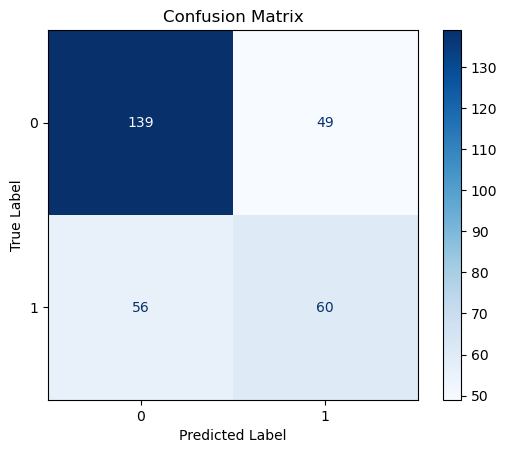

In [42]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix

cm = confusion_matrix(y_test_preprocessed, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# plot confusion matrix
disp.plot(cmap='Blues')

# add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

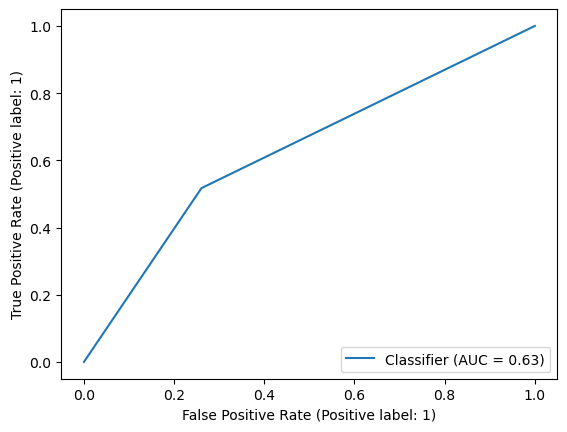

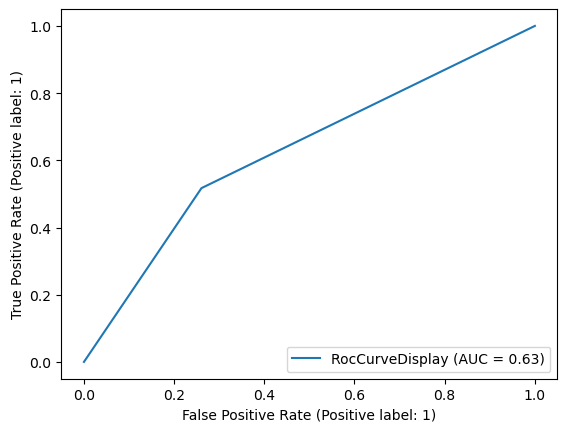

In [43]:
from sklearn.metrics import RocCurveDisplay

disp_roc_curve = RocCurveDisplay.from_predictions(y_true=y_test_preprocessed, y_pred=y_pred_binary)

# plot confusion matrix
disp_roc_curve.plot(name='RocCurveDisplay')

plt.show()

### Hyperparameter tuning: Grid Search and Cross validation
* create a default XGBoost classifier.
* create the Kfold object. You can use tratifiedKFold from sklearn.model_selection.
* create the grid search object. You can use RandomizedSearchCV from sklearn.model_selection.
* fit grid search.

In [44]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV


# Create the default XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Create the KFold object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=92847)

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 200, 500],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create the grid search object
grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    random_state=92847
)

# Fit the grid search object
grid_search.fit(X_train_preprocessed, y_train_preprocessed)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy Score:", grid_search.best_score_)

Best Hyperparameters: {'subsample': 1, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Accuracy Score: 0.6233589691695338


### Assessing model performance using the best model from grid search
#### Print Train Accuracy, Test Accuracy and Classification Report.

In [45]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the train and test data using the best model
y_train_pred = best_model.predict(X_train_preprocessed)
y_test_pred = best_model.predict(X_test_preprocessed)

# Evaluate the accuracy of the model on the train and test data
train_accuracy = accuracy_score(y_train_preprocessed, y_train_pred)
test_accuracy = accuracy_score(y_test_preprocessed, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report
print("Classification Report:\n", classification_report(y_test_preprocessed, y_test_pred))

Train Accuracy: 0.7245065789473685
Test Accuracy: 0.6677631578947368
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73       188
           1       0.57      0.54      0.56       116

    accuracy                           0.67       304
   macro avg       0.65      0.64      0.64       304
weighted avg       0.67      0.67      0.67       304



### Create the feature importances plot, plot a decision tree from the booster.

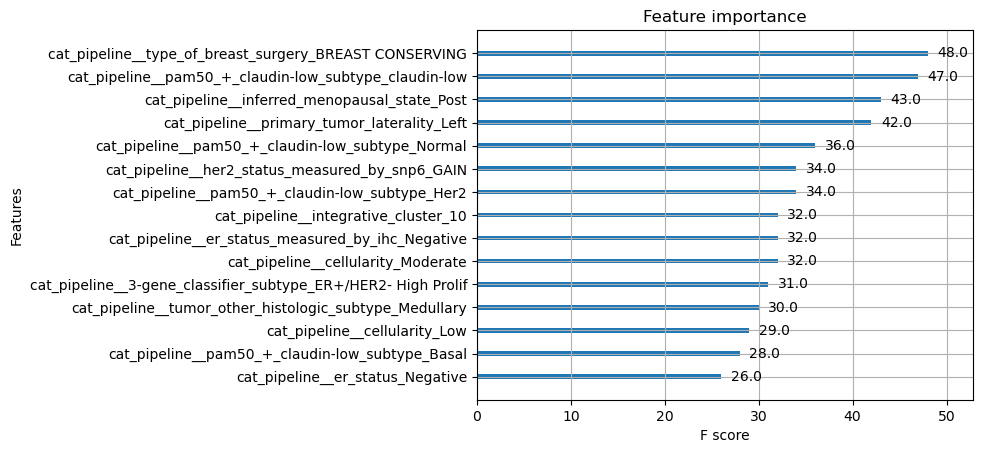

In [46]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

xgb_model = best_model

# Plot the feature importances
plot_importance(xgb_model, max_num_features=15)
plt.show()

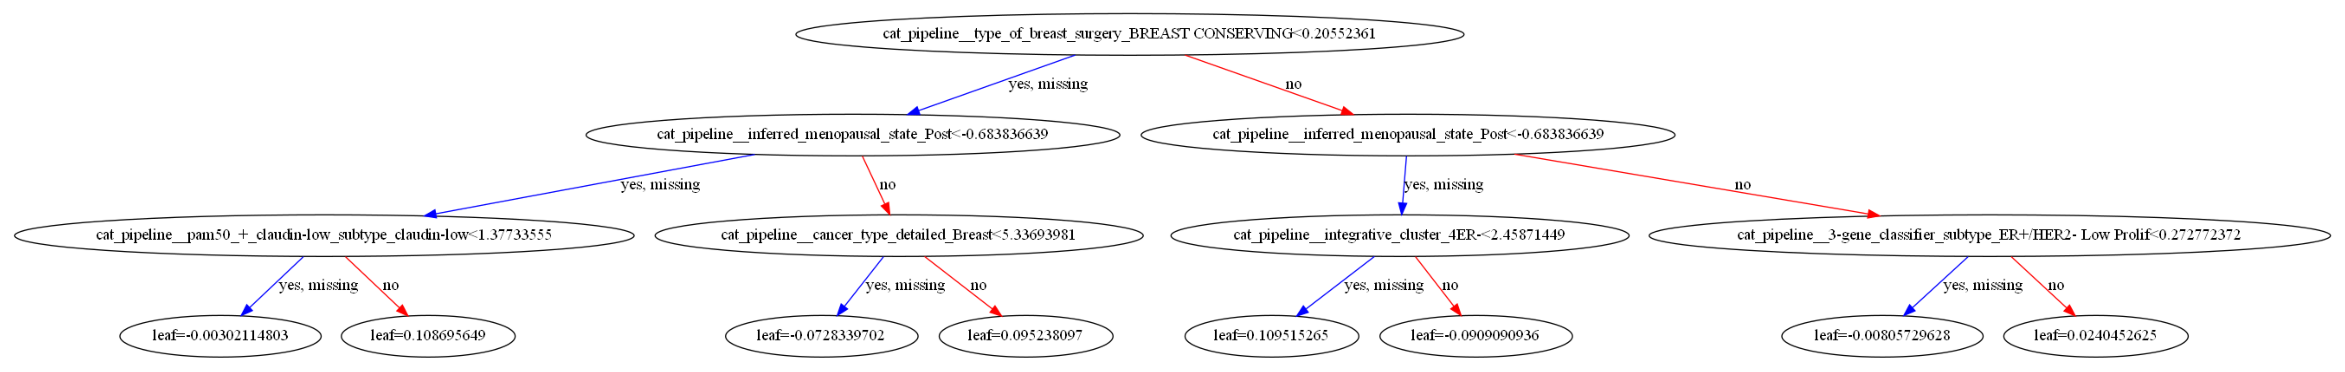

In [47]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(xgb_model, ax=ax)
plt.savefig('./images/decision_tree.png', dpi=600)
plt.show()


### * Improve Model (Bonus)
In this bonus part, you can add your ideas for improving your model's performance. You can implement your model and compare the results.

here are a few ideas for improving the performance of the XGBoost model:

Feature engineering: It may be possible to create new features or transform existing features in a way that makes them more informative for the model. For example, we could create new features by combining existing features or by performing mathematical operations on them.

Ensembling: We could try ensembling multiple models together to improve the overall performance. For example, we could try combining the XGBoost model with a random forest, or we could use a stacking approach where we train multiple models and use their predictions as features for a final model.

Regularization: We could adjust the regularization parameters of the XGBoost model to reduce overfitting and improve generalization performance. For example, we could increase the values of the reg_alpha and reg_lambda hyperparameters.

More advanced hyperparameter tuning: We could use more advanced methods for hyperparameter tuning, such as Bayesian optimization or genetic algorithms. These methods may be able to find better hyperparameters more efficiently than grid search or random search.

Here's an example of how we could perform feature engineering by creating a new feature that represents the ratio of the mean radius to the mean texture for each sample:

In [48]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset into a pandas dataframe
df_improved = pd.read_csv('breast_cancer.csv')
df_improved['tumor_score'] = df_improved['tumor_size'] * df_improved['neoplasm_histologic_grade']

# Create X feature matrix and y target vector
X = df_improved.drop('overall_survival', axis=1)
y = df_improved['overall_survival']

X_improved = x_preprocess_pipe.fit_transform(X)

X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(X_improved, y, test_size=0.2, random_state=92847)
# Create the default XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Create the KFold object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=92847)

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 200, 500],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Create the grid search object
grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    random_state=92847
)

# Fit the grid search object
grid_search.fit(X_train_improved, y_train_improved)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the train and test data using the best model
y_train_pred = best_model.predict(X_train_improved)
y_test_pred = best_model.predict(X_test_improved)

# Evaluate the accuracy of the model on the train and test data
train_accuracy = accuracy_score(y_train_improved, y_train_pred)
test_accuracy = accuracy_score(y_test_improved, y_test_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Print the classification report
print("Classification Report:\n", classification_report(y_test_improved, y_test_pred))

Train Accuracy: 0.6756401838476691
Test Accuracy: 0.6509186351706037
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.83      0.74       224
           1       0.62      0.39      0.48       157

    accuracy                           0.65       381
   macro avg       0.64      0.61      0.61       381
weighted avg       0.64      0.65      0.63       381



## Comparison between XGBoost and Random Forest Classifier

Compare the results from these two models. How Would you rate each method in terms of its performance? What's the difference between these models? explain.

Both XGBoost and Random Forest Classifier are popular tree-based ensemble methods used for classification tasks. Here's a comparison between the two:

Performance:

In terms of performance, both XGBoost and Random Forest Classifier can be very effective and achieve high accuracy on many datasets. However, the performance of each method can depend on the specific dataset and the hyperparameters used.

In general, XGBoost tends to perform slightly better than Random Forest Classifier on many datasets, especially when the dataset is large and complex. XGBoost is known for its ability to handle high-dimensional data and learn complex interactions between features.

However, Random Forest Classifier can sometimes perform better than XGBoost on smaller datasets or datasets with simpler relationships between features. Random Forest Classifier is also known for its ability to handle noisy data and outliers.

Difference between models:

The main difference between XGBoost and Random Forest Classifier is in how they build their decision trees.

Random Forest Classifier builds decision trees independently of each other, using a random subset of the features at each split. This helps to reduce overfitting and increase the diversity of the trees in the ensemble.

XGBoost builds decision trees sequentially, using the residuals of the previous trees to guide the construction of the next tree. This allows XGBoost to focus on the samples that are most difficult to classify and can lead to better performance.

XGBoost also includes additional regularization parameters, such as L1 and L2 regularization, that can help to further reduce overfitting and improve generalization performance.

Another difference is that XGBoost uses a gradient boosting approach, while Random Forest Classifier uses a bagging approach. This means that XGBoost tries to minimize the errors of the previous trees, while Random Forest Classifier tries to reduce the variance of the ensemble by averaging the predictions of the trees.

Overall, both XGBoost and Random Forest Classifier are powerful methods that can be effective for classification tasks. The choice between them may depend on the specific dataset and the performance requirements of the task.